In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout, RNN
from keras_tuner import BayesianOptimization, RandomSearch, GridSearch
import keras

2023-05-06 23:24:28.358022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Multivariate Time Series Forecasting with LSTMs

## 2.1. DATA prep and EDA

In [2]:
country = 'germany'

df_MRD = pd.read_excel(io = f'../../../data/processed/{country}.xlsx')

In [3]:
df_MRD.dtypes

Time                                                                                                                                                     datetime64[ns]
Unemployment_Rate_MEN                                                                                                                                           float64
Unemployment_Rate_TOT                                                                                                                                           float64
Unemployment_Rate_WOMEN                                                                                                                                         float64
Electricity_Distribution_Losses                                                                                                                                 float64
Electricity_Final_Consumption_(Calculated)                                                                                                                      

In [4]:
df_MRD = df_MRD.drop(columns = [
    'Unemployment_Rate_MEN', 'Unemployment_Rate_WOMEN', 
    'Labor_Markets|Unemployment_Rate|Percent', 'Unemployment|Persons|Number_of', 'Employment|Persons|Number_of'
    ], inplace = False
)

In [5]:
df_MRD = df_MRD.replace('-', np.NaN)
df_MRD['Government_Bonds'] = df_MRD['Government_Bonds'].astype(float)

In [6]:
df_MRD = df_MRD.set_index('Time')

### 2.1.5. Scaling and Trend Analysis

In [7]:
scaler=MinMaxScaler()

df_MRD_scaled=scaler.fit_transform(df_MRD)
df_MRD_scaled=pd.DataFrame(df_MRD_scaled,columns=df_MRD.columns)

df_MRD_scaled.index=df_MRD.index

In [8]:
for col in df_MRD_scaled.columns:
    max_time=df_MRD_scaled[~df_MRD_scaled[col].isna()].index[-1]
    print('%s : %s'%(col,max_time))

Unemployment_Rate_TOT : 2023-02-01 00:00:00
Electricity_Distribution_Losses : 2023-01-01 00:00:00
Electricity_Final_Consumption_(Calculated) : 2023-01-01 00:00:00
Natural_Gas_Trade_Balance : 2023-02-01 00:00:00
Economic_Activity|Industrial_Production|Index|Base_Year-2010=100 : 2022-11-01 00:00:00
Economic_Activity|Industrial_Production|Manufacturing|Index|Base_Year-2010=100 : 2022-11-01 00:00:00
Industrial_Production|Seasonally_adjusted|Index|Base_Year-2010=100 : 2022-11-01 00:00:00
Financial_Market_Prices|Equities|End_of_Period|Index|Base_Year-None : 2012-12-01 00:00:00
Prices|Consumer_Price_Index|All_items|Index|Base_Year-2010=100 : 2023-03-01 00:00:00
Prices|Producer_Price_Index|All_Commodities|Index|Base_Year-2010=100 : 2022-11-01 00:00:00
Change_in_Inventories|Nominal|Undjusted|Domestic_Currency : 2022-12-01 00:00:00
Exports_of_Goods_and_Services|Nominal|Undjusted|Domestic_Currency : 2022-12-01 00:00:00
Government_Consumption_Expenditure|Nominal|Undjusted|Domestic_Currency : 2022-

In [9]:
# col_not_available=[
#     'Financial Market Prices, Equities, Index','Central Bank Policy Rate','Deposit Rate',
#     'Discount Rate','Lending Rate', 'Money Market Rate','Treasury Bill Rate'
# ]
                   
# col_not_available_high_correlation=['Labor Markets, Wage Rates, Index','Government Bonds']

# seasonally_adjusted_col=[col for col in df_MRD_scaled.columns if re.search(r'Seasonally Adjusted',col,re.I)]
                   
# df_MRD.drop(columns=col_not_available + col_not_available_high_correlation,inplace=True)

## 2.2. Modelling

### 2.2.1. Reframe time series to supervised learning

In [10]:
df_MRD

,Unemployment_Rate_TOT,Electricity_Distribution_Losses,Electricity_Final_Consumption_(Calculated),Natural_Gas_Trade_Balance,Economic_Activity|Industrial_Production|Index|Base_Year-2010=100,Economic_Activity|Industrial_Production|Manufacturing|Index|Base_Year-2010=100,Industrial_Production|Seasonally_adjusted|Index|Base_Year-2010=100,Financial_Market_Prices|Equities|End_of_Period|Index|Base_Year-None,Prices|Consumer_Price_Index|All_items|Index|Base_Year-2010=100,Prices|Producer_Price_Index|All_Commodities|Index|Base_Year-2010=100,...,Harmonized_Euro_Area_Rates|Loans|Households|Consumer_Credit_and_Other|Up_to_1_Year,Harmonized_Euro_Area_Rates|Loans|Households|House_Purchase|Over_5_Years,Harmonized_Euro_Area_Rates|Loans|Non-Financial_Corporations|Up_to_1_Year,Harmonized_Euro_Area_Rates|New_Business|Deposits|Households|Agreed_Maturity|Up_to_1_Year,Harmonized_Euro_Area_Rates|New_Business|Deposits|Non-financial_Corporations|Agreed_Maturity|Up_to_1_Year,Harmonized_Euro_Area_Rates|New_Business|Loans|Households|Consumption|Floating_Rate_and_up_to_1_Year,Harmonized_Euro_Area_Rates|New_Business|Loans|Households|House_Purchase|Over_5_Years,Harmonized_Euro_Area_Rates|New_Business|Loans|Non-financial_Corporations|Other_Than_Bank_Overdrafts|Over_EUR_1_Million|Over_3_Months_and_up_to_1_Year,Harmonized_Euro_Area_Rates|Outstanding_Amounts|Deposits|Households|Agreed_Maturity|Up_to_2_Years,Harmonized_Euro_Area_Rates|Outstanding_Amounts|Deposits|Non-Financial_Corporations|Agreed_Maturity|Up_to_2_Years
Time,,,,,,,,,,,,,,,,,,,,,
1962-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,3.0,2417.3839,39886.3295,7773.754,113.184916,107.887663,104.972578,NaN,128.501897,147.698745,...,7.51,1.73,3.49,1.34,1.43,7.51,3.51,3.62,0.94,1.13
2022-12-01,3.0,2472.6610,40111.9312,8858.099,NaN,NaN,NaN,NaN,127.936805,NaN,...,7.73,1.74,3.70,1.53,1.66,7.64,3.41,3.83,1.16,1.39
2023-01-01,2.9,2616.2649,42614.8545,7933.526,NaN,NaN,NaN,NaN,129.180007,NaN,...,8.18,1.76,4.04,1.68,1.96,7.84,3.45,4.19,1.37,1.67


In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
reframed_dataset = series_to_supervised(df_MRD, 5, 1)

### 2.2.2. Feature Selection

#### 2.2.2.1.Feature selection based on availability

In [13]:
# tlag_col=[col for col in reframed_dataset.columns if re.search(r't\)',col,re.I)==None]
# reframed_dataset_final=reframed_dataset[tlag_col+['var5(t)']]

tlag_col=[col for col in reframed_dataset.columns if re.search(r't-5',col,re.I)!=None]
reframed_dataset_final=reframed_dataset[tlag_col+['var5(t-1)','var5(t-2)','var5(t-3)','var5(t-4)']+['var5(t)']]

reframed_dataset_final.dropna(inplace=True)
reframed_dataset_final

/tmp/ipykernel_511354/564800525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed_dataset_final.dropna(inplace=True)


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var48(t-5),var49(t-5),var50(t-5),var51(t-5),var52(t-5),var5(t-1),var5(t-2),var5(t-3),var5(t-4),var5(t)
Time,,,,,,,,,,,,,,,,,,,,,
2010-11-01,6.5,1800.706,41729.143,5973.687,103.589278,100.435629,99.817185,95.637940,99.908326,100.313808,...,3.41,3.90,2.95,1.58,0.86,107.514766,108.278055,93.339391,99.009541,111.549296
2010-12-01,6.4,1899.214,42830.622,6084.023,99.009541,99.657058,99.817185,98.668343,100.108346,100.627615,...,3.68,3.81,2.85,1.52,0.90,111.549296,107.514766,108.278055,93.339391,104.134484
2011-01-01,6.4,1840.361,42879.611,5713.932,93.339391,101.325424,101.133455,95.347730,100.208345,100.627615,...,3.69,3.81,3.06,1.50,0.92,104.134484,111.549296,107.514766,108.278055,96.610632
2011-02-01,6.3,1863.058,42607.020,5089.665,108.278055,102.771341,102.340037,100.504304,100.108346,100.836820,...,3.63,3.66,2.93,1.47,0.93,96.610632,104.134484,111.549296,107.514766,102.498864
2011-03-01,6.3,2002.439,46752.029,7791.452,107.514766,104.995829,104.533821,106.568165,100.208345,100.941423,...,3.64,3.58,2.63,1.47,0.98,102.498864,96.610632,104.134484,111.549296,117.655611
2011-04-01,6.2,2091.025,47662.608,7407.035,111.549296,104.439707,103.985375,108.037544,100.308355,101.046025,...,3.62,3.62,3.28,1.47,1.00,117.655611,102.498864,96.610632,104.134484,102.171740
2011-05-01,6.1,2289.845,51016.859,6899.043,104.134484,106.108073,105.959781,112.638136,100.908414,101.778243,...,3.38,3.73,3.21,1.46,1.03,102.171740,117.655611,102.498864,96.610632,112.966833
2011-06-01,6.0,2369.986,50144.653,8471.627,96.610632,105.885624,105.191956,114.584071,100.708394,102.615063,...,3.55,3.87,2.96,1.46,1.08,112.966833,102.171740,117.655611,102.498864,103.589278
2011-07-01,5.9,2176.322,46149.572,7765.989,102.498864,107.109093,106.288848,117.373141,101.308443,103.033473,...,3.54,4.04,2.99,1.46,1.10,103.589278,112.966833,102.171740,117.655611,105.333939


#### 2.2.2.1.Feature selection using causality test

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]

def check_stationarity(dataset):
    stationary_fields=[]
    non_stationary_fields=[]
    for col in dataset.columns:
        print('______%s_______'%col)
        p_value=adf_test(dataset[col])
        if p_value<=0.05:
            stationary_fields.append(col)
        else:
            non_stationary_fields.append(col)

    print('Number of stationary fields :%s'%len(stationary_fields))
    print('Number of non stationary fields :%s'%len(non_stationary_fields))
    
    return stationary_fields,non_stationary_fields

In [15]:
stationary_fields,non_stationary_fields=check_stationarity(reframed_dataset_final)

______var1(t-5)_______
ADF Statistics: -2.142796
p-value: 0.227658
Critical values:
	1%: -3.788
	5%: -3.013
	10%: -2.646
______var2(t-5)_______
ADF Statistics: -4.476722
p-value: 0.000217
Critical values:
	1%: -3.770
	5%: -3.005
	10%: -2.643
______var3(t-5)_______
ADF Statistics: -4.640463
p-value: 0.000109
Critical values:
	1%: -3.724
	5%: -2.986
	10%: -2.633
______var4(t-5)_______
ADF Statistics: -3.146362
p-value: 0.023307
Critical values:
	1%: -3.788
	5%: -3.013
	10%: -2.646
______var5(t-5)_______
ADF Statistics: -1.343059
p-value: 0.609250
Critical values:
	1%: -3.788
	5%: -3.013
	10%: -2.646
______var6(t-5)_______
ADF Statistics: -2.540257
p-value: 0.105984
Critical values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
______var7(t-5)_______
ADF Statistics: -2.800000
p-value: 0.058274
Critical values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
______var8(t-5)_______
ADF Statistics: -2.292517
p-value: 0.174393
Critical values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
______var9(t-5)_______
ADF Stati

In [16]:
reframed_dataset_final_transformed = reframed_dataset_final.diff().dropna()
stationary_fields,non_stationary_fields=check_stationarity(reframed_dataset_final_transformed)

______var1(t-5)_______
ADF Statistics: -0.499163
p-value: 0.892180
Critical values:
	1%: -3.788
	5%: -3.013
	10%: -2.646
______var2(t-5)_______
ADF Statistics: -3.466651
p-value: 0.008886
Critical values:
	1%: -3.809
	5%: -3.022
	10%: -2.651
______var3(t-5)_______
ADF Statistics: -3.359062
p-value: 0.012436
Critical values:
	1%: -3.788
	5%: -3.013
	10%: -2.646
______var4(t-5)_______
ADF Statistics: -4.037933
p-value: 0.001224
Critical values:
	1%: -3.809
	5%: -3.022
	10%: -2.651
______var5(t-5)_______
ADF Statistics: -0.927675
p-value: 0.778722
Critical values:
	1%: -3.809
	5%: -3.022
	10%: -2.651
______var6(t-5)_______
ADF Statistics: -7.471974
p-value: 0.000000
Critical values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
______var7(t-5)_______
ADF Statistics: -7.235181
p-value: 0.000000
Critical values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
______var8(t-5)_______
ADF Statistics: -4.055518
p-value: 0.001146
Critical values:
	1%: -3.689
	5%: -2.972
	10%: -2.625
______var9(t-5)_______
ADF Stati

In [17]:
non_stationary_fields.remove('var1(t-5)')

In [18]:
reframed_dataset_final_transformed.drop(columns=non_stationary_fields,inplace=True)

In [19]:
reframed_dataset_final_transformed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var40(t-5),var42(t-5),var48(t-5),var5(t-1),var5(t-2),var5(t)
Time,,,,,,,,,,,,,,,
2010-12-01,-0.1,98.508,1101.479,110.336,-0.778571,0.000000,3.030403,0.200020,0.313808,0.503503,0.08,0.27,4.034530,-0.763289,-7.414811
2011-01-01,0.0,-58.853,48.989,-370.091,1.668366,1.316271,-3.320613,0.099999,0.000000,0.484273,-0.27,0.01,-7.414811,4.034530,-7.523853
2011-02-01,-0.1,22.697,-272.591,-624.267,1.445917,1.206581,5.156573,-0.099999,0.209205,0.344914,-0.05,-0.06,-7.523853,-7.414811,5.888233
2011-03-01,0.0,139.381,4145.009,2701.787,2.224488,2.193784,6.063861,0.099999,0.104603,0.195467,0.05,0.01,5.888233,-7.523853,15.156747
2011-04-01,-0.1,88.586,910.579,-384.417,-0.556122,-0.548446,1.469379,0.100010,0.104603,0.127646,0.18,-0.02,15.156747,5.888233,-15.483871
2011-05-01,-0.1,198.820,3354.251,-507.992,1.668366,1.974406,4.600592,0.600060,0.732218,-0.000725,0.38,-0.24,-15.483871,15.156747,10.795093
2011-06-01,-0.1,80.141,-872.206,1572.584,-0.222449,-0.767824,1.945934,-0.200020,0.836820,-0.056037,0.09,0.17,10.795093,-15.483871,-9.377556
2011-07-01,-0.1,-193.664,-3995.081,-705.638,1.223468,1.096892,2.789071,0.600048,0.418410,-0.076856,0.20,-0.01,-9.377556,10.795093,1.744662
2011-08-01,-0.2,79.710,2100.760,944.219,0.667346,0.438757,-2.984581,0.600048,0.418410,-0.122555,0.01,0.19,1.744662,-9.377556,-2.180827


In [20]:
correlated_col=[]
for col in [col for col in reframed_dataset_final_transformed.columns if col!='var1(t-5)']:
    print('_____________Granger Causality test between Unemployment Rate and %s___________________'%(col))
    granger_ = grangercausalitytests(reframed_dataset_final_transformed[['var1(t-5)', col]], 4)
    if (granger_[1][0]['ssr_chi2test'][1]<=0.05)|(granger_[2][0]['ssr_chi2test'][1]<=0.05)|(granger_[3][0]['ssr_chi2test'][1]<=0.05)|(granger_[4][0]['ssr_chi2test'][1]<=0.05):
        correlated_col.append(col)

_____________Granger Causality test between Unemployment Rate and var2(t-5)___________________

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4847  , p=0.4925  , df_denom=26, df_num=1
ssr based chi2 test:   chi2=0.5406  , p=0.4622  , df=1
likelihood ratio test: chi2=0.5357  , p=0.4642  , df=1
parameter F test:         F=0.4847  , p=0.4925  , df_denom=26, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8065  , p=0.4586  , df_denom=23, df_num=2
ssr based chi2 test:   chi2=1.9638  , p=0.3746  , df=2
likelihood ratio test: chi2=1.8980  , p=0.3871  , df=2
parameter F test:         F=0.8065  , p=0.4586  , df_denom=23, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9666  , p=0.1515  , df_denom=20, df_num=3
ssr based chi2 test:   chi2=7.9645  , p=0.0468  , df=3
likelihood ratio test: chi2=6.9794  , p=0.0726  , df=3
parameter F test:         F=1.9666  , p=0.1515  , df_denom=20, df_num=3

Gran

In [21]:
reframed_dataset_final_features=reframed_dataset_final[correlated_col+['var1(t-5)']].copy()

In [22]:
reframed_dataset_final_features

,var2(t-5),var3(t-5),var6(t-5),var7(t-5),var9(t-5),var40(t-5),var1(t-5)
Time,,,,,,,
2010-11-01,1800.706,41729.143,100.435629,99.817185,99.908326,100.184753,6.5
2010-12-01,1899.214,42830.622,99.657058,99.817185,100.108346,100.688256,6.4
2011-01-01,1840.361,42879.611,101.325424,101.133455,100.208345,101.172529,6.4
2011-02-01,1863.058,42607.020,102.771341,102.340037,100.108346,101.517442,6.3
2011-03-01,2002.439,46752.029,104.995829,104.533821,100.208345,101.712909,6.3
2011-04-01,2091.025,47662.608,104.439707,103.985375,100.308355,101.840554,6.2
2011-05-01,2289.845,51016.859,106.108073,105.959781,100.908414,101.839830,6.1
2011-06-01,2369.986,50144.653,105.885624,105.191956,100.708394,101.783793,6.0
2011-07-01,2176.322,46149.572,107.109093,106.288848,101.308443,101.706938,5.9


### 2.2.3. Split to train-test and reframe

In [23]:
scaler=MinMaxScaler()
reframed_dataset_final_scaled=scaler.fit_transform(reframed_dataset_final_features)
reframed_dataset_final_scaled=pd.DataFrame(reframed_dataset_final_scaled,columns=reframed_dataset_final_features.columns)

reframed_dataset_final_scaled.index=reframed_dataset_final_features.index

In [24]:
reframed_dataset_final_scaled

,var2(t-5),var3(t-5),var6(t-5),var7(t-5),var9(t-5),var40(t-5),var1(t-5)
Time,,,,,,,
2010-11-01,0.000000,0.101288,0.066667,0.000000,0.000000,0.052055,1.000000
2010-12-01,0.173040,0.207871,0.000000,0.000000,0.039216,0.340310,0.933333
2011-01-01,0.069658,0.212612,0.142857,0.133333,0.058822,0.617556,0.933333
2011-02-01,0.109528,0.186235,0.266667,0.255556,0.039216,0.815019,0.866667
2011-03-01,0.354365,0.587320,0.457143,0.477778,0.058822,0.926923,0.866667
2011-04-01,0.509976,0.675431,0.409524,0.422222,0.078430,1.000000,0.800000
2011-05-01,0.859224,1.000000,0.552381,0.622222,0.196079,0.999585,0.733333
2011-06-01,1.000000,0.915602,0.533333,0.544444,0.156863,0.967504,0.666667
2011-07-01,0.659809,0.529024,0.638095,0.655556,0.274510,0.923504,0.600000


In [25]:
reframed_dataset_final_scaled_values=reframed_dataset_final_scaled.values

train_limit=reframed_dataset_final_scaled_values.shape[0]-12

train_X=reframed_dataset_final_scaled_values[0:train_limit,:-1]
train_Y=reframed_dataset_final_scaled_values[0:train_limit,-1]

test_X=reframed_dataset_final_scaled_values[train_limit:,:-1]
test_Y=reframed_dataset_final_scaled_values[train_limit:,-1]

In [26]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(19, 1, 6) (19,) (12, 1, 6) (12,)


### 2.2.4. Hyperparameter Tuning using GridSearch

2023-05-06 23:24:59.702526: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100


2023-05-06 23:25:00.131521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 23:25:00.133842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 23:25:00.135452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 - 4s - loss: 0.5121 - val_loss: 0.0274 - 4s/epoch - 4s/step
Epoch 2/100
1/1 - 0s - loss: 0.5004 - val_loss: 0.0285 - 48ms/epoch - 48ms/step
Epoch 3/100
1/1 - 0s - loss: 0.4886 - val_loss: 0.0407 - 120ms/epoch - 120ms/step
Epoch 4/100
1/1 - 0s - loss: 0.4769 - val_loss: 0.0534 - 127ms/epoch - 127ms/step
Epoch 5/100
1/1 - 0s - loss: 0.4651 - val_loss: 0.0661 - 126ms/epoch - 126ms/step
Epoch 6/100
1/1 - 0s - loss: 0.4533 - val_loss: 0.0789 - 103ms/epoch - 103ms/step
Epoch 7/100
1/1 - 0s - loss: 0.4414 - val_loss: 0.0918 - 97ms/epoch - 97ms/step
Epoch 8/100
1/1 - 0s - loss: 0.4295 - val_loss: 0.1046 - 77ms/epoch - 77ms/step
Epoch 9/100
1/1 - 0s - loss: 0.4204 - val_loss: 0.1172 - 78ms/epoch - 78ms/step
Epoch 10/100
1/1 - 0s - loss: 0.4115 - val_loss: 0.1298 - 116ms/epoch - 116ms/step
Epoch 11/100
1/1 - 0s - loss: 0.4027 - val_loss: 0.1422 - 133ms/epoch - 133ms/step
Epoch 12/100
1/1 - 0s - loss: 0.3938 - val_loss: 0.1547 - 177ms/epoch - 177ms/step
Epoch 13/100
1/1 - 0s - loss: 0.3849 - 

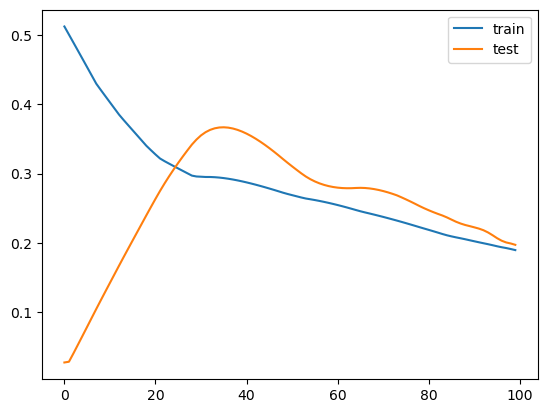

In [27]:
# Fitting model without any hyperparameter tuning
model_no_tuned = Sequential()
model_no_tuned.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_no_tuned.add(Dense(1))
model_no_tuned.compile(loss='mae', optimizer='adam')
# fit network
history = model_no_tuned.fit(train_X, train_Y, epochs=100, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [28]:
# make a prediction
yhat = model_no_tuned.predict(test_X)

# invert scaling for forecast
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((test_X_reshaped, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_Y_reshaped = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_X_reshaped,test_Y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

1/1 [==============================] - 1s 579ms/step


2023-05-06 23:25:18.250447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 23:25:18.253186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 23:25:18.254917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [29]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %s' % rmse)

Test RMSE: 0.3222002736952096


In [30]:
# Fitting best model using hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(hp.Int('input_unit',min_value=10,max_value=500,step=1),return_sequences=True, 
                   input_shape=(train_X.shape[1],train_X.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=10,max_value=500,step=1),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=10,max_value=500,step=1)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.99,step=0.1)))
    
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['sigmoid','relu','tanh','linear','selu','elu'],
                                            default='relu')))
    
    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),metrics =['mse'])
    return model

tuner= GridSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=1,
        overwrite=True,
        project_name=f'keras_tuning_{country}_LSTM'
        )

tuner.search(
        x=train_X,
        y=train_Y,
        epochs=100,
        batch_size=72,
        validation_data=(test_X,test_Y),
)

Trial 10 Complete [00h 00m 14s]
mse: 0.0037011548411101103

Best mse So Far: 0.002310585230588913
Total elapsed time: 00h 04m 42s
INFO:tensorflow:Oracle triggered exit


In [31]:
best_model = tuner.get_best_models(num_models=1)[0]

2023-05-06 23:30:04.759360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 23:30:04.761252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 23:30:04.762832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [32]:
# make a prediction
yhat = best_model.predict(test_X)

# invert scaling for forecast
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((test_X_reshaped, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_Y_reshaped = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_X_reshaped,test_Y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

2023-05-06 23:30:08.581985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 23:30:08.583872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 23:30:08.585853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


In [33]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %s' % rmse)

Test RMSE: 0.23048426570299163
